# Deep Learning - Gesture Recognition Project

### Problem Statement :

Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

    Gesture	      Corresponding Action
    Thumbs Up	   Increase the volume.
    Thumbs Down	   Decrease the volume.
    Left Swipe	  'Jump' backwards 10 seconds.
    Right Swipe	  'Jump' forward 10 seconds.
    Stop	       Pause the movie.

In [1]:
import numpy as np
import os
from scipy.misc.pilutil import imread , imresize
import datetime
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
% matplotlib inline

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.random.set_seed(30) -- new code not working in Nimble, which worked in my Local Anaconda Set up
tf.set_random_seed(30)

Using TensorFlow backend.


In [4]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout

In [5]:
path ='./Project_data'

In [6]:
class GestureControl():
    
    def create_model(self):
        pass

    def set_general_parameters(self,image_width=120,image_height =120):
        self.image_width = image_width
        self.image_height = image_height
        self.num_classes = 5
        self.channels = 3
        self.total_frames = 30
        
    def set_hyperparameters(self,num_epochs =10,batch_size = 10,frames_to_sample=30):
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.frames_to_sample = frames_to_sample
        
    def set_paths_for_validation(self,path):
        self.train_doc = np.random.permutation(open(path + '/'+'train.csv').readlines())
        self.val_doc = np.random.permutation(open(path + '/'+'val.csv').readlines())
        self.train_path = path + '/'+'train'
        self.val_path = path + '/'+'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def generator(self,source_path, folder_list):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int) #create a list of image numbers you want to use for a particular video
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size # calculate the number of batches
            
            for batch in range(num_batches): # we iterate over the number of batches
                batch_data, batch_labels = self.call_common_data(source_path,t,batch,batch_size,img_idx)
                yield batch_data, batch_labels
                
            # write the code for the remaining data points which are left after full batches
            remaining_seq = len(t)% batch_size
            if(remaining_seq != 0):
                batch_data, batch_labels = self.call_common_data(source_path,t,batch,batch_size,img_idx,remaining_seq)
                yield batch_data, batch_labels

    def call_common_data(self,source_path,t,batch,batch_size,img_idx,remaining_seq=0):
        
        seq_len = remaining_seq if remaining_seq else batch_size
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))# x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
        batch_labels = np.zeros((seq_len, self.num_classes)) # batch_labels is the one hot representation of the output
        
        for folder in range(seq_len): # iterate over the batch_size
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
            for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
                #crop the images and resize them. Note that the images are of 2 different shape 
                #and the conv3D will throw error if the inputs in a batch have different shapes

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255 #normalise and feed in the image
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255 #normalise and feed in the image
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255 #normalise and feed in the image

            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
        return(batch_data,batch_labels)

    def set_model_for_training(self,model):
        train_generator = self.generator(self.train_path, self.train_doc)
        val_generator = self.generator(self.val_path, self.val_doc)
        
        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
        
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4) # write the REducelronplateau code here
        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]
        
        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
        
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, workers=1,class_weight=None,initial_epoch=0)
        return history      

In [7]:
# Initial Model - will try to build model with more layer (complex model) based on result we will try to simplified further
class ModelConv3D_1(GestureControl):
    def create_model(self):
        
        model = Sequential()
        model.add(Conv3D(16,(3,3,3),padding='same',input_shape=(self.frames_to_sample,self.image_height,self.image_width,3)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))

        model.add(Conv3D(32,(2,2,2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))

        model.add(Conv3D(64,(2,2,2),padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))

        model.add(Conv3D(128,(2,2,2),padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))

        model.add(Flatten())
        model.add(Dense(128, activation ='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64, activation = 'relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))

        model.add(Dense(self.num_classes,activation='softmax'))
        optimiser = optimizers.Adam()  #optimiser = 'sgd' #write your optimizer
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

## Model 1 - Conv3D : Base model to check all code is working

In [7]:
conv3D1 = ModelConv3D_1()
conv3D1.set_paths_for_validation(path)
conv3D1.set_general_parameters(image_width=120,image_height =120)
conv3D1.set_hyperparameters(num_epochs =1,batch_size = 5,frames_to_sample=30)
model_conv3D1 = conv3D1.create_model()
model_conv3D1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 32)    4128      
_________________________________________________________________
activation_2 (Activation)    (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 60, 60, 32)    128       
__________

In [8]:
conv3D1.set_model_for_training(model_conv3D1)

Epoch 1/1
133/133 [==============================] - 193s 1s/step - loss: 1.7033 - categorical_accuracy: 0.3529 - val_loss: 1.5574 - val_categorical_accuracy: 0.4000

Epoch 00001: val_loss improved from inf to 1.55740, saving model to model_init_2020-12-1912_37_41.511253/model-00001-1.70490-0.35294-1.55740-0.40000.h5


## Model OOM - Conv3D : Changing Image Size and Batch Size to see Any impact

In [8]:
conv3DOOM = ModelConv3D_1()
conv3DOOM.set_paths_for_validation(path)
conv3DOOM.set_general_parameters(image_width=160,image_height =160)
conv3DOOM.set_hyperparameters(num_epochs =1,batch_size = 40,frames_to_sample=30)
model_conv3DOOM = conv3DOOM.create_model()
model_conv3DOOM.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 80, 80, 32)    4128      
_________________________________________________________________
activation_2 (Activation)    (None, 15, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 80, 80, 32)    128       
__________

In [11]:
# OOM - ResourceExhaustedError we tried below model with batch_size = 40, image(160,160) and frames_to_sample=30
# conv3DOOM.set_model_for_training(model_conv3DOOM)

Epoch 1/1


ResourceExhaustedError: OOM when allocating tensor with shape[40,16,30,160,160] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training/Adam/gradients/max_pooling3d_1/MaxPool3D_grad/MaxPool3DGrad = MaxPool3DGrad[T=DT_FLOAT, TInput=DT_FLOAT, _class=["loc:@training/Adam/gradients/batch_normalization_1/cond/Merge_grad/cond_grad"], data_format="NDHWC", ksize=[1, 2, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 2, 1], _device="/job:localhost/replica:0/task:0/device:GPU:0"](batch_normalization_1/cond/Merge, max_pooling3d_1/MaxPool3D, training/Adam/gradients/conv3d_2/convolution_grad/Conv3DBackpropInputV2)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [8]:
def plot_accuracy(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['train_loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['train_categorical_accuracy','val_categorical_accuracy'])

## Model 2 - Conv3D : Batch Size = 30, No. of Epochs = 15,Dense neurons=64,Dropout=0.25

In [13]:
class ModelConv3D_2(GestureControl):
    
    def create_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,3)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [14]:
conv3D1 = ModelConv3D_2()
conv3D1.set_paths_for_validation(path)
conv3D1.set_general_parameters(image_width=160,image_height =160)
conv3D1.set_hyperparameters(num_epochs =15,batch_size = 30,frames_to_sample=30)
model_conv3D1 = conv3D1.create_model()
model_conv3D1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
activation_9 (Activation)    (None, 30, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 30, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 15, 80, 80, 32)    13856     
_________________________________________________________________
activation_10 (Activation)   (None, 15, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 15, 80, 80, 32)    128       
__________

In [15]:
model1_history = conv3D1.set_model_for_training(model_conv3D1)

Epoch 1/15
23/23 [==============================] - 103s 4s/step - loss: 1.4811 - categorical_accuracy: 0.4396 - val_loss: 2.2089 - val_categorical_accuracy: 0.5100

Epoch 00001: val_loss improved from inf to 2.20890, saving model to model_init_2020-12-1913_27_33.463987/model-00001-1.52868-0.41780-2.20890-0.51000.h5
Epoch 2/15
23/23 [==============================] - 87s 4s/step - loss: 0.9696 - categorical_accuracy: 0.6478 - val_loss: 1.5670 - val_categorical_accuracy: 0.5400

Epoch 00002: val_loss improved from 2.20890 to 1.56696, saving model to model_init_2020-12-1913_27_33.463987/model-00002-0.95216-0.64706-1.56696-0.54000.h5
Epoch 3/15
23/23 [==============================] - 90s 4s/step - loss: 0.8389 - categorical_accuracy: 0.6646 - val_loss: 1.2155 - val_categorical_accuracy: 0.6800

Epoch 00003: val_loss improved from 1.56696 to 1.21548, saving model to model_init_2020-12-1913_27_33.463987/model-00003-0.85111-0.65158-1.21548-0.68000.h5
Epoch 4/15
23/23 [======================

#### Observation : 
-As we can see from above results,there is High gap between Training  and Validation Accuracy. 
-So "Model is Overfitting"

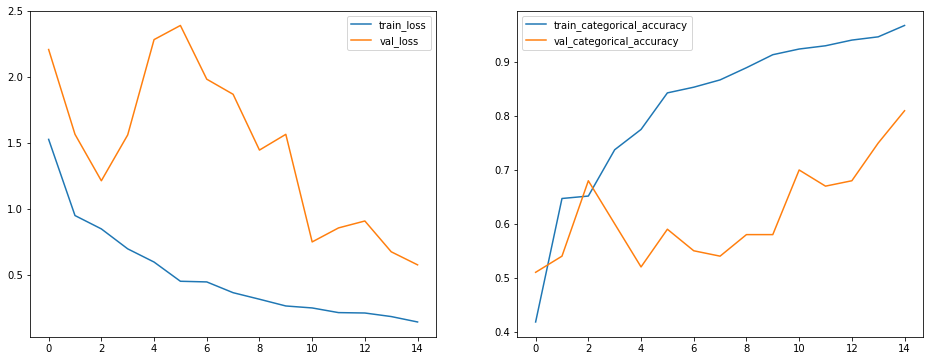

In [21]:
plot_accuracy(model1_history)

## Model 3 - Conv3D : Batch Size = 20,No. of Epochs = 15,Dense neurons=256,Dropout=0.25
- We try one more model with different parameters and Layers
- We will add more layers and add Dropout to reduce parameters

In [24]:
class ModelConv3D_3(GestureControl):
    
    def create_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,3)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,3)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [25]:
conv3D3 = ModelConv3D_3()
conv3D3.set_paths_for_validation(path)
conv3D3.set_general_parameters(image_width=120,image_height =120)
conv3D3.set_hyperparameters(num_epochs =15,batch_size = 20,frames_to_sample=16)
model_conv3D3 = conv3D3.create_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
model_conv3D3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_13 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_13 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_14 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 8, 60, 60, 16)     0         
__________

In [26]:
model3_history = conv3D3.set_model_for_training(model_conv3D3)

Epoch 1/15
34/34 [==============================] - 55s 2s/step - loss: 1.7667 - categorical_accuracy: 0.4010 - val_loss: 1.8299 - val_categorical_accuracy: 0.4600

Epoch 00001: val_loss improved from inf to 1.82991, saving model to model_init_2020-12-1914_35_22.194202/model-00001-1.75202-0.40271-1.82991-0.46000.h5
Epoch 2/15
34/34 [==============================] - 44s 1s/step - loss: 1.3717 - categorical_accuracy: 0.4739 - val_loss: 3.1283 - val_categorical_accuracy: 0.3000

Epoch 00002: val_loss did not improve from 1.82991
Epoch 3/15
34/34 [==============================] - 44s 1s/step - loss: 1.1632 - categorical_accuracy: 0.5592 - val_loss: 1.9725 - val_categorical_accuracy: 0.4000

Epoch 00003: val_loss did not improve from 1.82991
Epoch 4/15
34/34 [==============================] - 44s 1s/step - loss: 0.9865 - categorical_accuracy: 0.6144 - val_loss: 2.6211 - val_categorical_accuracy: 0.3700

Epoch 00004: val_loss did not improve from 1.82991
Epoch 5/15
34/34 [=================

#### Obervation:
- So we add more layers but that also did not help in getting higher Accuracy
- Also we can see adding Dropout did not help in getting Validation Accuracy
- Model is highly overfitting

## Model 4 - Conv3D : Batch Size = 20,No. of Epochs = 25,Dense neurons=64,Dropout=0.25
- Since in Previous Layer we did not achieve result for model 4 we will reduce layers

In [28]:
class ModelConv3D_4(GestureControl):
    
    def create_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,3)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [29]:
conv3D4 = ModelConv3D_4()
conv3D4.set_paths_for_validation(path)
conv3D4.set_general_parameters(image_width=120,image_height =120)
conv3D4.set_hyperparameters(num_epochs =25,batch_size = 20,frames_to_sample=16)
model_conv3D4 = conv3D4.create_model(dense_neurons=63,dropout=0.25)
model_conv3D4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_19 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_19 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_17 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_20 (Conv3D)           (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
activation_20 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 8, 60, 60, 32)     128       
__________

In [30]:
model4_history = conv3D4.set_model_for_training(model_conv3D4)

Epoch 1/25
34/34 [==============================] - 46s 1s/step - loss: 1.8755 - categorical_accuracy: 0.3348 - val_loss: 1.3596 - val_categorical_accuracy: 0.4300

Epoch 00001: val_loss improved from inf to 1.35958, saving model to model_init_2020-12-1915_00_49.399812/model-00001-1.89560-0.33484-1.35958-0.43000.h5
Epoch 2/25
34/34 [==============================] - 39s 1s/step - loss: 1.2707 - categorical_accuracy: 0.5070 - val_loss: 1.0486 - val_categorical_accuracy: 0.6100

Epoch 00002: val_loss improved from 1.35958 to 1.04860, saving model to model_init_2020-12-1915_00_49.399812/model-00002-1.26063-0.51131-1.04860-0.61000.h5
Epoch 3/25
34/34 [==============================] - 42s 1s/step - loss: 0.9442 - categorical_accuracy: 0.6284 - val_loss: 0.9726 - val_categorical_accuracy: 0.6000

Epoch 00003: val_loss improved from 1.04860 to 0.97261, saving model to model_init_2020-12-1915_00_49.399812/model-00003-0.92941-0.64404-0.97261-0.60000.h5
Epoch 4/25
34/34 [=======================

#### Observation :
- So we can see after this approach we are able to get bast accuracy upto 78%
- Still we can see from result that Model is Still overfitting and not generalize enough

## Model 5 - CNNRNN - LSTM

In [37]:
class CNNRNN_1(GestureControl):
    
    def create_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Flatten()))
        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [38]:
cnn_rnn1 = CNNRNN_1()
cnn_rnn1.set_paths_for_validation(path)
cnn_rnn1.set_general_parameters(image_width=120,image_height =120)
cnn_rnn1.set_hyperparameters(num_epochs =20,batch_size = 20,frames_to_sample=18)
model_cnnrnn1 = cnn_rnn1.create_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
model_cnnrnn1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_17 (TimeDis (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_18 (TimeDis (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_19 (TimeDis (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_20 (TimeDis (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_21 (TimeDis (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_22 (TimeDis (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_23 (TimeDis (None, 18, 30, 30, 64)    18496     
__________

In [39]:
model5_history = cnn_rnn1.set_model_for_training(model_cnnrnn1)

Epoch 1/20
34/34 [==============================] - 53s 2s/step - loss: 1.5145 - categorical_accuracy: 0.3326 - val_loss: 1.2537 - val_categorical_accuracy: 0.4300

Epoch 00001: val_loss improved from inf to 1.25371, saving model to model_init_2020-12-1915_33_42.260308/model-00001-1.50218-0.34087-1.25371-0.43000.h5
Epoch 2/20
34/34 [==============================] - 43s 1s/step - loss: 1.2371 - categorical_accuracy: 0.4717 - val_loss: 1.2281 - val_categorical_accuracy: 0.5200

Epoch 00002: val_loss improved from 1.25371 to 1.22812, saving model to model_init_2020-12-1915_33_42.260308/model-00002-1.23338-0.47511-1.22812-0.52000.h5
Epoch 3/20
34/34 [==============================] - 48s 1s/step - loss: 1.0532 - categorical_accuracy: 0.5497 - val_loss: 1.0470 - val_categorical_accuracy: 0.5400

Epoch 00003: val_loss improved from 1.22812 to 1.04701, saving model to model_init_2020-12-1915_33_42.260308/model-00003-1.05235-0.55505-1.04701-0.54000.h5
Epoch 4/20
34/34 [=======================

#### Observation :
- So in CNN-RNN Model we are able to get 78% accuracy in validation.
- We have try many possible combination but not able to achieve Desire Result
- So we will try data augmentation in Generator class and run model on that

In [11]:
class GestureControlAugmentation():
    
    def create_model(self):
        pass

    def set_general_parameters(self,image_width=100,image_height =100):
        self.image_width = image_width
        self.image_height = image_height
        self.num_classes = 5
        self.channels = 3
        self.total_frames = 30
        
    def set_hyperparameters(self,num_epochs =20,batch_size = 20,frames_to_sample=30):
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.frames_to_sample = frames_to_sample
        
    def set_paths_for_validation(self,path):
        self.train_doc = np.random.permutation(open(path + '/'+'train.csv').readlines())
        self.val_doc = np.random.permutation(open(path + '/'+'val.csv').readlines())
        self.train_path = path + '/'+'train'
        self.val_path = path + '/'+'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int) #create a list of image numbers you want to use for a particular video
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size # calculate the number of batches
            
            for batch in range(num_batches): # we iterate over the number of batches
                batch_data, batch_labels = self.call_common_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels
                
            # write the code for the remaining data points which are left after full batches
            remaining_seq = len(t)% batch_size
            if(remaining_seq != 0):
                batch_data, batch_labels = self.call_common_data(source_path,t,batch,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels

    def call_common_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
        
        seq_len = remaining_seq if remaining_seq else batch_size
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))# x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
        batch_labels = np.zeros((seq_len, self.num_classes)) # batch_labels is the one hot representation of the output
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))
        
        for folder in range(seq_len): # iterate over the batch_size
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
            for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
                #crop the images and resize them. Note that the images are of 2 different shape 
                #and the conv3D will throw error if the inputs in a batch have different shapes

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255 #normalise and feed in the image
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255 #normalise and feed in the image
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255 #normalise and feed in the image
                
                if (augment):
                    shifted = cv2.warpAffine(image, np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), (image.shape[1], image.shape[0]))
                    
                    grayscale = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)
                    x0, y0 = np.argwhere(grayscale > 0).min(axis=0)
                    x1, y1 = np.argwhere(grayscale > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    Matx = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, Matx, (self.image_width, self.image_height))
                    
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                

            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])
        return(batch_data,batch_labels)

    def set_model_for_training(self,model,augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)
        
        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
        
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4) # write the REducelronplateau code here
        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]
        
        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
        
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, workers=1,class_weight=None,initial_epoch=0)
        return history

## Model 6 - Conv3D - Batch Size = 20,No. of Epochs = 20,Dense neurons=256,Dropout=0.5

In [43]:
class ModelConv3D_6(GestureControlAugmentation):
    
    def create_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [44]:
conv3D6 = ModelConv3D_6()
conv3D6.set_paths_for_validation(path)
conv3D6.set_general_parameters(image_width=160,image_height =160)
conv3D6.set_hyperparameters(num_epochs =20,batch_size = 20,frames_to_sample=20)
model_conv3D6 = conv3D6.create_model(dense_neurons=256,dropout=0.5)
model_conv3D6.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_23 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_23 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_43 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_21 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_24 (Conv3D)           (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_24 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_44 (Batc (None, 10, 80, 80, 32)    128       
__________

In [45]:
model6_history = conv3D6.set_model_for_training(model_conv3D6)

Epoch 1/20
34/34 [==============================] - 68s 2s/step - loss: 2.0596 - categorical_accuracy: 0.3687 - val_loss: 1.5477 - val_categorical_accuracy: 0.4000

Epoch 00001: val_loss improved from inf to 1.54766, saving model to model_init_2020-12-1916_34_24.499428/model-00001-2.00989-0.36953-1.54766-0.40000.h5
Epoch 2/20
34/34 [==============================] - 53s 2s/step - loss: 1.4466 - categorical_accuracy: 0.5166 - val_loss: 1.5028 - val_categorical_accuracy: 0.4800

Epoch 00002: val_loss improved from 1.54766 to 1.50282, saving model to model_init_2020-12-1916_34_24.499428/model-00002-1.47262-0.51282-1.50282-0.48000.h5
Epoch 3/20
34/34 [==============================] - 59s 2s/step - loss: 1.2191 - categorical_accuracy: 0.5629 - val_loss: 0.9327 - val_categorical_accuracy: 0.6300

Epoch 00003: val_loss improved from 1.50282 to 0.93265, saving model to model_init_2020-12-1916_34_24.499428/model-00003-1.18057-0.56863-0.93265-0.63000.h5
Epoch 4/20
34/34 [=======================

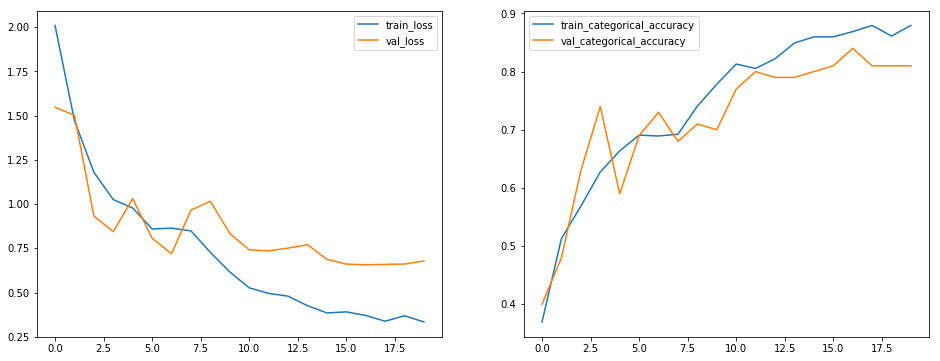

In [51]:
plot_accuracy(model6_history)

### Observation:
- So data Augmentation works well and we achieved good accuracy in both (train and Validation).
- Able to achieve (87% training and 84% validation accuracy).
- So for next model we will Use Augmentation and change hyperparamer.

## Model 7 - Conv3D - Reducing filtersize=(2,2,2) and dense neurons=256 and dropout=0.5

In [48]:
class ModelConv3D_7(GestureControlAugmentation):
    
    def create_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [50]:
conv3D7 = ModelConv3D_7()
conv3D7.set_paths_for_validation(path)
conv3D7.set_general_parameters(image_width=120,image_height =120)
conv3D7.set_hyperparameters(num_epochs =25,batch_size = 30,frames_to_sample=16)
model_conv3D7 = conv3D7.create_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
model_conv3D7.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_27 (Conv3D)           (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation_27 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_49 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_25 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_28 (Conv3D)           (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_28 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_50 (Batc (None, 8, 60, 60, 32)     128       
__________

In [52]:
model7_history = conv3D7.set_model_for_training(model_conv3D7)

Epoch 1/25
23/23 [==============================] - 47s 2s/step - loss: 2.1650 - categorical_accuracy: 0.3063 - val_loss: 1.3692 - val_categorical_accuracy: 0.4700

Epoch 00001: val_loss improved from inf to 1.36924, saving model to model_init_2020-12-1917_16_57.774123/model-00001-2.13316-0.31825-1.36924-0.47000.h5
Epoch 2/25
23/23 [==============================] - 36s 2s/step - loss: 1.6237 - categorical_accuracy: 0.4689 - val_loss: 1.0996 - val_categorical_accuracy: 0.6400

Epoch 00002: val_loss improved from 1.36924 to 1.09964, saving model to model_init_2020-12-1917_16_57.774123/model-00002-1.53286-0.48718-1.09964-0.64000.h5
Epoch 3/25
23/23 [==============================] - 41s 2s/step - loss: 1.2479 - categorical_accuracy: 0.5255 - val_loss: 0.9081 - val_categorical_accuracy: 0.7000

Epoch 00003: val_loss improved from 1.09964 to 0.90808, saving model to model_init_2020-12-1917_16_57.774123/model-00003-1.23335-0.54600-0.90808-0.70000.h5
Epoch 4/25
23/23 [=======================

#### Observation :
- So after reducing filtersize from (3,3,3) to (2,2,2) but did not get better result.
- Model is badly overfitting in this approch.

## General Observation:
- So after trying multiple hyperparameter and model Augmentation we are able to achieve good accuracy but not the best
- So To achieve higher Accuracy we can use Transafer learning for already available model

## Model 8 - CNNRNN - LSTM + Mobilenet (TL) : Weights are not trained
- Since we need to use model for webcam it's important we select light architecture.
- VGG16, Alexnet, InceptionV3 are heavyweight architecture and also consume high Disk Space.
- In our experiment we found that Using VGGnet we are not getting better accuracy and it require high disk space
- So we have removed model from code.
- So we will use mobilenet model as it's light architecture.

In [9]:
from keras.applications import mobilenet

In [14]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
class TL1_CNNRNN(GestureControlAugmentation):
    
    def create_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        for layer in model.layers:
            layer.trainable = False
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
 
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [15]:
tl1_cnnrnn = TL1_CNNRNN()
tl1_cnnrnn.set_paths_for_validation(path)
tl1_cnnrnn.set_general_parameters(image_width=120,image_height =120)
tl1_cnnrnn.set_hyperparameters(num_epochs =18,batch_size =5,frames_to_sample=16)
model_TL1CNNRNN8 = tl1_cnnrnn.create_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
model_TL1CNNRNN8.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_2 (TimeDist (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 16, 1024)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               590336    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
__________

In [16]:
model8_history = tl1_cnnrnn.set_model_for_training(model_TL1CNNRNN8)

Epoch 1/18
133/133 [==============================] - 117s 878ms/step - loss: 1.5108 - categorical_accuracy: 0.3444 - val_loss: 1.4823 - val_categorical_accuracy: 0.4000

Epoch 00001: val_loss improved from inf to 1.48233, saving model to model_init_2020-12-2005_19_13.862596/model-00001-1.51023-0.34540-1.48233-0.40000.h5
Epoch 2/18
133/133 [==============================] - 40s 303ms/step - loss: 1.2789 - categorical_accuracy: 0.4732 - val_loss: 1.3549 - val_categorical_accuracy: 0.4000

Epoch 00002: val_loss improved from 1.48233 to 1.35494, saving model to model_init_2020-12-2005_19_13.862596/model-00002-1.27846-0.47360-1.35494-0.40000.h5
Epoch 3/18
133/133 [==============================] - 42s 312ms/step - loss: 1.0380 - categorical_accuracy: 0.6176 - val_loss: 1.4081 - val_categorical_accuracy: 0.4200

Epoch 00003: val_loss did not improve from 1.35494
Epoch 4/18
133/133 [==============================] - 41s 309ms/step - loss: 0.9992 - categorical_accuracy: 0.6176 - val_loss: 1.0

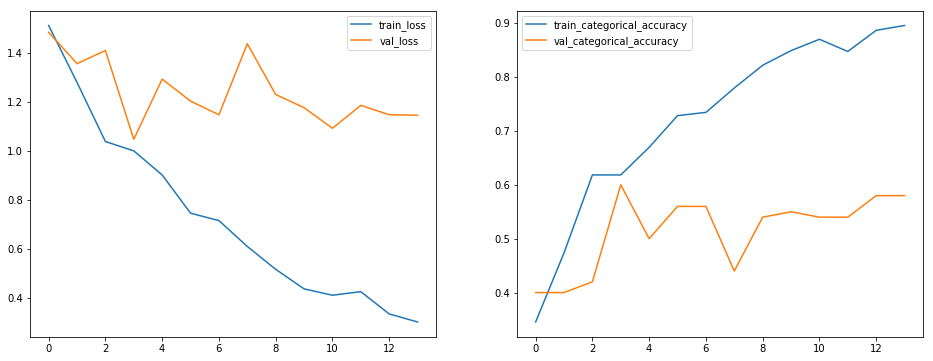

In [21]:
plot_accuracy(model8_history)

#### Observation:
- So we can see using this model also we are not able to get result.
- Model is overfitting and validation accuracy is very bad.
- So for next model we can train LT model weights and use GRU instead of LSTM

## Model 9 - CNNRNN - GRU + Mobilenet (TL) : Weights are trained

In [18]:
mobilenet_tf = mobilenet.MobileNet(weights='imagenet', include_top=False)
class TL2_CNNRNN(GestureControlAugmentation):
    
    def create_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_tf,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [19]:
tl2_cnnrnn = TL2_CNNRNN()
tl2_cnnrnn.set_paths_for_validation(path)
tl2_cnnrnn.set_general_parameters(image_width=120,image_height =120)
tl2_cnnrnn.set_hyperparameters(num_epochs =20,batch_size =5,frames_to_sample=16)
model_TL2CNNRNN9 = tl2_cnnrnn.create_model(gru_cells=128,dense_neurons=128,dropout=0.25)
model_TL2CNNRNN9.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_5 (TimeDist (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_6 (TimeDist (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_7 (TimeDist (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, 16, 1024)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               442752    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
__________

In [20]:
model9_history = tl2_cnnrnn.set_model_for_training(model_TL2CNNRNN9)

Epoch 1/20
133/133 [==============================] - 56s 424ms/step - loss: 1.2519 - categorical_accuracy: 0.4902 - val_loss: 0.8767 - val_categorical_accuracy: 0.7000

Epoch 00001: val_loss improved from inf to 0.87669, saving model to model_init_2020-12-2005_39_46.176134/model-00001-1.25441-0.48869-0.87669-0.70000.h5
Epoch 2/20
133/133 [==============================] - 46s 344ms/step - loss: 0.8002 - categorical_accuracy: 0.6917 - val_loss: 0.5684 - val_categorical_accuracy: 0.7800

Epoch 00002: val_loss improved from 0.87669 to 0.56839, saving model to model_init_2020-12-2005_39_46.176134/model-00002-0.80173-0.69080-0.56839-0.78000.h5
Epoch 3/20
133/133 [==============================] - 46s 344ms/step - loss: 0.5901 - categorical_accuracy: 0.7855 - val_loss: 0.5674 - val_categorical_accuracy: 0.7400

Epoch 00003: val_loss improved from 0.56839 to 0.56742, saving model to model_init_2020-12-2005_39_46.176134/model-00003-0.59046-0.78582-0.56742-0.74000.h5
Epoch 4/20
133/133 [======

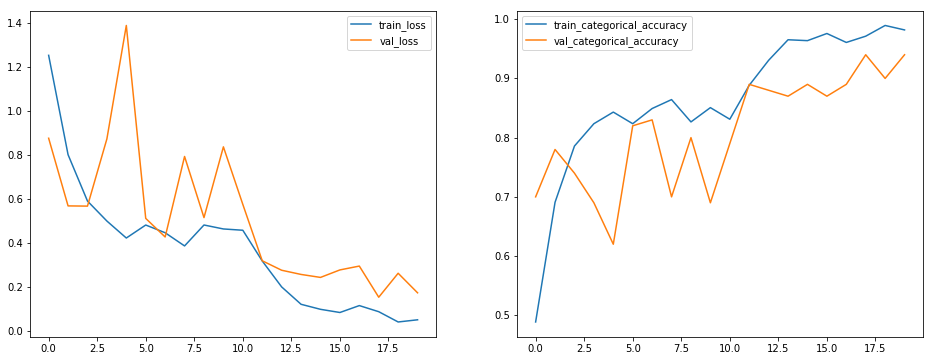

In [22]:
plot_accuracy(model9_history)

#### Observation:
- So we can see we have achieved best Accuracy so far.
- training accuracy 97% and validation accuracy 94%.
- We can see that this model is able generalise.

#### So best model File is : model_init_2020-12-2005_39_46.176134/model-00018-0.08635-0.97134-0.15233-0.94000.h5